# **Multitask Model Training**
This model is designed to perform two tasks simultaneously on tweet text:


*   **Emotion analysis (8 emotions)**
*   **Sarcasm detection (binary)**

The base model used for this project is ***`vinai/bertweet-base`***.

## **Dataset class & Dataloaders**

**Define PyTorch Dataset Classes**

This code defines two PyTorch dataset classes, EmotionDataset and SarcasmDataset, for emotion and sarcasm classification tasks. Each class tokenizes input texts using a Hugging Face tokenizer, pads/truncates them to a fixed length, and returns input tensors along with their labels for model training or evaluation.

In [1]:
import pandas as pd
from torch.utils.data import Dataset, DataLoader
from transformers import AutoTokenizer

class EmotionDataset(Dataset):
    def __init__(self, texts, labels, tokenizer, max_length=128):
        self.texts = texts
        self.labels = labels
        self.tokenizer = tokenizer
        self.max_length = max_length

    def __len__(self):
        return len(self.texts)

    def __getitem__(self, idx):
        encoding = self.tokenizer(
            self.texts[idx],
            padding="max_length",
            truncation=True,
            max_length=self.max_length,
            return_tensors="pt"
        )
        item = {key: val.squeeze(0) for key, val in encoding.items()}
        item["labels"] = self.labels[idx]
        return item

class SarcasmDataset(Dataset):
    def __init__(self, texts, labels, tokenizer, max_length=128):
        self.texts = texts
        self.labels = labels
        self.tokenizer = tokenizer
        self.max_length = max_length

    def __len__(self):
        return len(self.texts)

    def __getitem__(self, idx):
        encoding = self.tokenizer(
            self.texts[idx],
            padding="max_length",
            truncation=True,
            max_length=self.max_length,
            return_tensors="pt"
        )
        item = {key: val.squeeze(0) for key, val in encoding.items()}
        item["labels"] = self.labels[idx]
        return item

**Define function to load emotion and sarcasm datasets**

The functions to load emotion and sarcasm datasets from CSV files, returning train, validation, and test sets as PyTorch datasets with tokenized text and labels.

In [2]:
def load_emotion_datasets(tokenizer):
    train_df = pd.read_csv("emotion_train.csv")
    val_df = pd.read_csv("emotion_validation.csv")
    test_df = pd.read_csv("emotion_test.csv")

    return (
        EmotionDataset(train_df["text"].tolist(), train_df["emotion_label"].tolist(), tokenizer),
        EmotionDataset(val_df["text"].tolist(), val_df["emotion_label"].tolist(), tokenizer),
        EmotionDataset(test_df["text"].tolist(), test_df["emotion_label"].tolist(), tokenizer),
    )

def load_sarcasm_datasets(tokenizer):
    train_df = pd.read_csv("sarcasm_train.csv")
    val_df = pd.read_csv("sarcasm_validation.csv")
    test_df = pd.read_csv("sarcasm_test.csv")

    return (
        SarcasmDataset(train_df["text"].tolist(), train_df["sarcasm_label"].tolist(), tokenizer),
        SarcasmDataset(val_df["text"].tolist(), val_df["sarcasm_label"].tolist(), tokenizer),
        SarcasmDataset(test_df["text"].tolist(), test_df["sarcasm_label"].tolist(), tokenizer),
    )


**Function to return data loader**

Creates and returns DataLoaders for emotion and sarcasm datasets with specified batch sizes for training, validation, and testing.

In [3]:
def get_dataloaders(emotion_batch_size=64, sarcasm_batch_size=16):
    tokenizer = AutoTokenizer.from_pretrained("vinai/bertweet-base")

    # Load datasets
    emotion_train, emotion_val, emotion_test = load_emotion_datasets(tokenizer)
    sarcasm_train, sarcasm_val, sarcasm_test = load_sarcasm_datasets(tokenizer)

    # Create DataLoaders
    emotion_train_loader = DataLoader(emotion_train, batch_size=emotion_batch_size, shuffle=True)
    emotion_val_loader = DataLoader(emotion_val, batch_size=emotion_batch_size, shuffle=False)
    emotion_test_loader = DataLoader(emotion_test, batch_size=emotion_batch_size, shuffle=False)

    sarcasm_train_loader = DataLoader(sarcasm_train, batch_size=sarcasm_batch_size, shuffle=True)
    sarcasm_val_loader = DataLoader(sarcasm_val, batch_size=sarcasm_batch_size, shuffle=False)
    sarcasm_test_loader = DataLoader(sarcasm_test, batch_size=sarcasm_batch_size, shuffle=False)

    return emotion_train_loader, sarcasm_train_loader, emotion_val_loader, sarcasm_val_loader, emotion_test_loader, sarcasm_test_loader

## **Define multitask model**
Defines a multitask model using BERTweet with separate classification heads for emotion (multi-class) and sarcasm (binary) detection, selecting the output based on the specified task.

In [4]:
import torch
import torch.nn as nn
from transformers import AutoModel

class MultiTaskModel(nn.Module):
    def __init__(self, pretrained_model_name="vinai/bertweet-base", num_emotions=8):
        super(MultiTaskModel, self).__init__()
        self.bert = AutoModel.from_pretrained(pretrained_model_name)
        self.dropout = nn.Dropout(0.3)
        hidden_size = self.bert.config.hidden_size

        # Emotion classification head
        self.emotion_classifier = nn.Linear(hidden_size, num_emotions)
        # Sarcasm classification head (binary classification)
        self.sarcasm_classifier = nn.Linear(hidden_size, 2)

    def forward(self, input_ids, attention_mask, task):
        # Get hidden states from BERT
        outputs = self.bert(input_ids=input_ids, attention_mask=attention_mask)

        # Use the [CLS] token embedding (first token)
        pooled_output = outputs.last_hidden_state[:, 0]

        # Choose output head based on task
        if task == "emotion":
            logits = self.emotion_classifier(pooled_output)
        elif task == "sarcasm":
            logits = self.sarcasm_classifier(pooled_output)
        else:
            raise ValueError("Task must be 'emotion' or 'sarcasm'")

        return logits

## **Evaluation functions**

**Imports**

In [5]:
import torch
from sklearn.metrics import (
    accuracy_score,
    precision_score,
    recall_score,
    f1_score,
    confusion_matrix
)
import matplotlib.pyplot as plt
import seaborn as sns
import json
import os
from datetime import datetime
from zoneinfo import ZoneInfo

**Function to evaluate model on given task**

Evaluates the model on a given task and dataloader, computing accuracy, precision, recall, and F1-score while collecting all predictions and labels for analysis.

In [6]:
def evaluate_task(model, dataloader, device, task_name):
    model.eval()
    all_preds, all_labels = [], []

    with torch.no_grad():
        for batch in dataloader:
            input_ids = batch["input_ids"].to(device)
            attention_mask = batch["attention_mask"].to(device)
            labels = batch["labels"].to(device)

            outputs = model(input_ids=input_ids, attention_mask=attention_mask, task=task_name)

            logits = outputs

            preds = torch.argmax(logits, dim=1)
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    acc = accuracy_score(all_labels, all_preds)
    precision = precision_score(all_labels, all_preds, average="macro", zero_division=0)
    recall = recall_score(all_labels, all_preds, average="macro", zero_division=0)
    f1 = f1_score(all_labels, all_preds, average="macro", zero_division=0)

    return {
        "task": task_name,
        "accuracy": acc,
        "precision": precision,
        "recall": recall,
        "f1": f1,
        "labels": all_labels,
        "preds": all_preds
    }

**Function to plot confusion matrix**

Plots and optionally saves or displays the confusion matrix for the given true and predicted labels of a specified task.

In [7]:
def plot_confusion_matrix(y_true, y_pred, task_name, save_path=None, show=False):
    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")
    plt.title(f"{task_name.capitalize()} Confusion Matrix")
    plt.xlabel("Predicted")
    plt.ylabel("True")
    plt.tight_layout()

    if save_path:
        plt.savefig(save_path)
    if show:
        plt.show()
    plt.close()

**Function to evaluate the multitask model**

Evaluates the multitask model on emotion and sarcasm datasets, prints metrics, computes combined F1 score, and optionally saves or displays confusion matrices and metrics to files.

In [8]:
def evaluate_multitask(model, emotion_loader, sarcasm_loader, device, save_dir=None, save=False):
    emotion_results = evaluate_task(model, emotion_loader, device, "emotion")
    sarcasm_results = evaluate_task(model, sarcasm_loader, device, "sarcasm")
    combined_f1 = (emotion_results["f1"] + sarcasm_results["f1"]) / 2

    result_data = {
        "emotion_metrics": {k: v for k, v in emotion_results.items() if k not in ["labels", "preds"]},
        "sarcasm_metrics": {k: v for k, v in sarcasm_results.items() if k not in ["labels", "preds"]},
        "combined_macro_f1": combined_f1
    }

    # Print metrics
    print("Emotion Task Metrics:")
    for k, v in result_data["emotion_metrics"].items():
        print(f"{k}: {v:.4f}" if isinstance(v, float) else f"{k}: {v}")

    print("\nSarcasm Task Metrics:")
    for k, v in result_data["sarcasm_metrics"].items():
        print(f"{k}: {v:.4f}" if isinstance(v, float) else f"{k}: {v}")

    # Plot and/or save confusion matrices
    timestamp = datetime.now(ZoneInfo("Asia/Kuala_Lumpur")).strftime("%Y%m%d_%H%M%S") if save else None
    if save and save_dir is not None:
        os.makedirs(save_dir, exist_ok=True)
        plot_confusion_matrix(emotion_results["labels"], emotion_results["preds"],
                              "emotion", os.path.join(save_dir, f"emotion_cm_{timestamp}.png"), show=True)
        plot_confusion_matrix(sarcasm_results["labels"], sarcasm_results["preds"],
                              "sarcasm", os.path.join(save_dir, f"sarcasm_cm_{timestamp}.png"), show=True)

        with open(os.path.join(save_dir, f"eval_metrics_{timestamp}.json"), "w") as f:
            json.dump(result_data, f, indent=4)
    else:
        # Show confusion matrices
        plot_confusion_matrix(emotion_results["labels"], emotion_results["preds"], "emotion", show=True)
        plot_confusion_matrix(sarcasm_results["labels"], sarcasm_results["preds"], "sarcasm", show=True)

    return result_data, combined_f1

## **Model Training**


**Imports**

In [9]:
import torch
import torch.nn as nn
from torch.optim import AdamW
import os
from itertools import cycle
from tqdm import tqdm
import copy

**Function to train the multitask model**

Trains the multitask model on emotion and sarcasm datasets for multiple epochs with early stopping based on validation combined F1 score. It optimizes a weighted loss, updates progress with tqdm, evaluates on train/validation sets each epoch, saves the best model, and stops training if no improvement after given patience.

In [10]:
def train_multitask(
    model,
    emotion_train_loader,
    sarcasm_train_loader,
    emotion_val_loader,
    sarcasm_val_loader,
    device,
    save_dir,
    epochs=5,
    patience=2,
    lr=2e-5
):
    optimizer = AdamW(model.parameters(), lr=lr, weight_decay=0.01)
    loss_fn = nn.CrossEntropyLoss()

    best_combined_f1 = 0.0
    patience_counter = 0
    best_model_state = None

    for epoch in range(epochs):
        model.train()
        total_emotion_loss = 0.0
        total_sarcasm_loss = 0.0

        num_steps = len(emotion_train_loader)
        step_iterator = tqdm(
            zip(emotion_train_loader, cycle(sarcasm_train_loader)),
            total=num_steps,
            desc=f"Epoch {epoch+1}/{epochs}",
            leave=False
        )

        for step, (emotion_batch, sarcasm_batch) in enumerate(step_iterator, start=1):
            optimizer.zero_grad()

            emotion_input_ids = emotion_batch['input_ids'].to(device)
            emotion_attention_mask = emotion_batch['attention_mask'].to(device)
            emotion_labels = emotion_batch['labels'].to(device)

            sarcasm_input_ids = sarcasm_batch['input_ids'].to(device)
            sarcasm_attention_mask = sarcasm_batch['attention_mask'].to(device)
            sarcasm_labels = sarcasm_batch['labels'].to(device)

            emotion_logits = model(emotion_input_ids, emotion_attention_mask, task="emotion")
            sarcasm_logits = model(sarcasm_input_ids, sarcasm_attention_mask, task="sarcasm")

            emotion_loss = loss_fn(emotion_logits, emotion_labels)
            sarcasm_loss = loss_fn(sarcasm_logits, sarcasm_labels)

            loss = 1.2 * emotion_loss + sarcasm_loss
            loss.backward()
            torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
            optimizer.step()

            total_emotion_loss += emotion_loss.item()
            total_sarcasm_loss += sarcasm_loss.item()

            # Live update of tqdm bar with running averages
            avg_emotion_loss = total_emotion_loss / step
            avg_sarcasm_loss = total_sarcasm_loss / step
            step_iterator.set_postfix({
                "Emotion Loss": f"{avg_emotion_loss:.4f}",
                "Sarcasm Loss": f"{avg_sarcasm_loss:.4f}"
            })
        print(f"-------------------------------------------")
        print(f"\nEpoch {epoch+1}/{epochs} completed.")
        print(f"→ Avg Emotion Loss: {avg_emotion_loss:.4f}, Avg Sarcasm Loss: {avg_sarcasm_loss:.4f}")

         # Evaluate on training datasets
        print("\nEvaluating on training datasets...")
        train_result_data, train_combined_macro_f1 = evaluate_multitask(
            model, emotion_train_loader, sarcasm_train_loader, device, save=False
        )
        print(f"→ Training Combined Macro F1: {train_combined_macro_f1:.4f}")

        # Evaluate on validation datasets
        print("\nEvaluating on validation datasets...")
        val_result_data, combined_macro_f1 = evaluate_multitask(
            model, emotion_val_loader, sarcasm_val_loader, device, save=False
        )
        print(f"→ Validation Combined Macro F1: {combined_macro_f1:.4f}")

        if combined_macro_f1 > best_combined_f1:
            best_combined_f1 = combined_macro_f1
            best_model_state = copy.deepcopy(model.state_dict())
            patience_counter = 0
            print("\nNew best model found. Saving model state.")
            os.makedirs(save_dir, exist_ok=True)
            save_path = os.path.join(save_dir, "best_multitask_model.pth")
            torch.save(best_model_state, save_path)
            print(f"Best model saved to '{save_path}'")
        else:
            patience_counter += 1
            print(f"\nNo improvement. Patience counter: {patience_counter}")

        if patience_counter >= patience:
            print("\nEarly stopping triggered.")
            break

    if best_model_state:
        model.load_state_dict(best_model_state)
        print("-----------------------------------")
        print('The best model evaluation on validation dataset:')
        evaluate_multitask(
            model, emotion_val_loader, sarcasm_val_loader, device, save_dir, save=True
        )


**Setup**

Sets device (GPU if available), batch sizes, training parameters, and creates directories to save training/validation and test results.

In [11]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
emotion_batch_size = 64  # 24,816 samples
sarcasm_batch_size = 16  # 3,681 samples
epochs = 5
patience = 2
learning_rate = 2e-5

train_val_results_dir = "./results/train_val"
test_results_dir = "./results/test"
os.makedirs(train_val_results_dir, exist_ok=True)
os.makedirs(test_results_dir, exist_ok=True)

In [12]:
!pip install emoji==0.6.0

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 51.0/51.0 kB 5.0 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for emoji: filename=emoji-0.6.0-py3-none-any.whl size=49719 sha256=9bf4e53d7d411d3692e0d27ed4adbd3ee04365dbc90a6686e0299c676478632a
  Stored in directory: /root/.cache/pip/wheels/b7/23/31/f9b93f25b95da9b91729c4cd5f35a2b692ab06f688f6759630
Successfully built emoji


**Load the dataloaders**

In [13]:
print("Loading dataloaders...")
emotion_train_loader, sarcasm_train_loader, emotion_val_loader, sarcasm_val_loader, emotion_test_loader, sarcasm_test_loader = get_dataloaders(
    emotion_batch_size=emotion_batch_size,
    sarcasm_batch_size=sarcasm_batch_size
)
print("Dataloaders loaded.")

Loading dataloaders...


/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


config.json:   0%|          | 0.00/558 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/843k [00:00<?, ?B/s]

bpe.codes:   0%|          | 0.00/1.08M [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/2.91M [00:00<?, ?B/s]

Dataloaders loaded.


**Initialize the multitask model**

In [14]:
print("Initializing model...")
model = MultiTaskModel().to(device)
print("Model initialized.")

Initializing model...


pytorch_model.bin:   0%|          | 0.00/543M [00:00<?, ?B/s]

Model initialized.


**The training starts**

Start training...


Epoch 1/5:   0%|          | 0/388 [00:00<?, ?it/s]

model.safetensors:   0%|          | 0.00/543M [00:00<?, ?B/s]

-------------------------------------------

Epoch 1/5 completed.
→ Avg Emotion Loss: 1.2096, Avg Sarcasm Loss: 0.5176

Evaluating on training datasets...
Emotion Task Metrics:
task: emotion
accuracy: 0.7072
precision: 0.6402
recall: 0.5408
f1: 0.5356

Sarcasm Task Metrics:
task: sarcasm
accuracy: 0.8679
precision: 0.8861
recall: 0.8640
f1: 0.8653


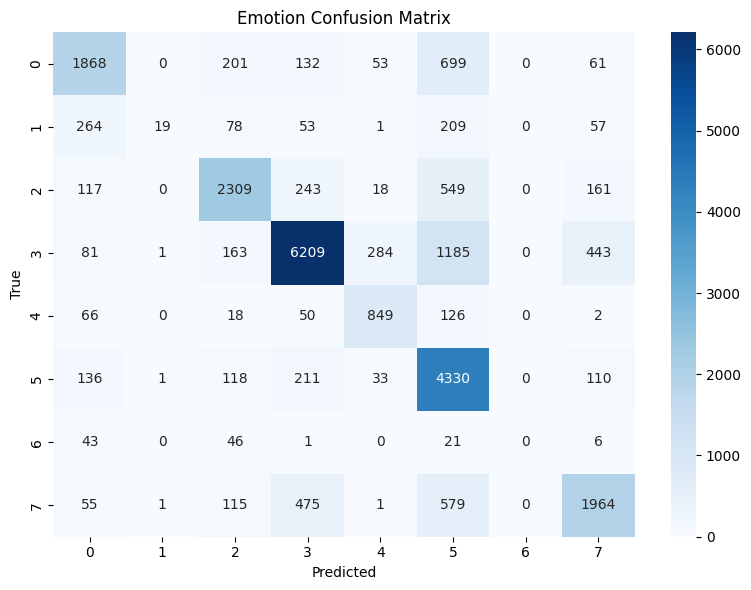

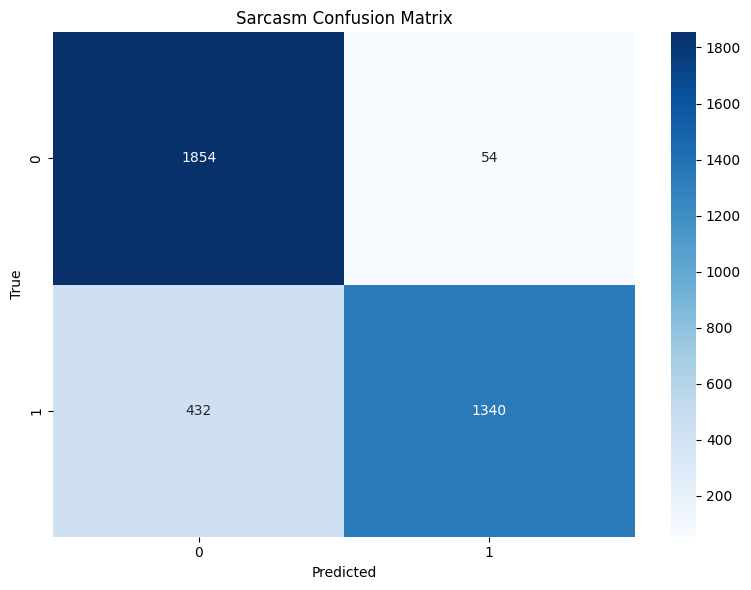

→ Training Combined Macro F1: 0.7004

Evaluating on validation datasets...
Emotion Task Metrics:
task: emotion
accuracy: 0.6886
precision: 0.6391
recall: 0.5258
f1: 0.5193

Sarcasm Task Metrics:
task: sarcasm
accuracy: 0.7804
precision: 0.8142
recall: 0.7790
f1: 0.7738


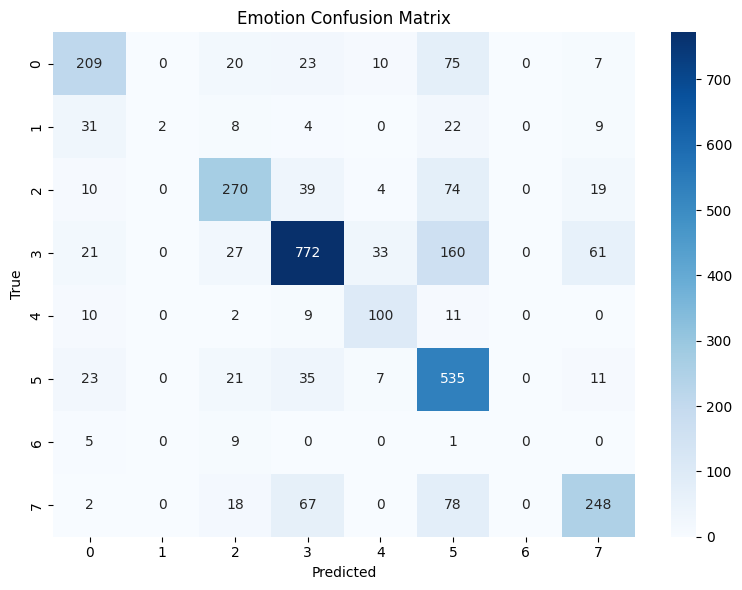

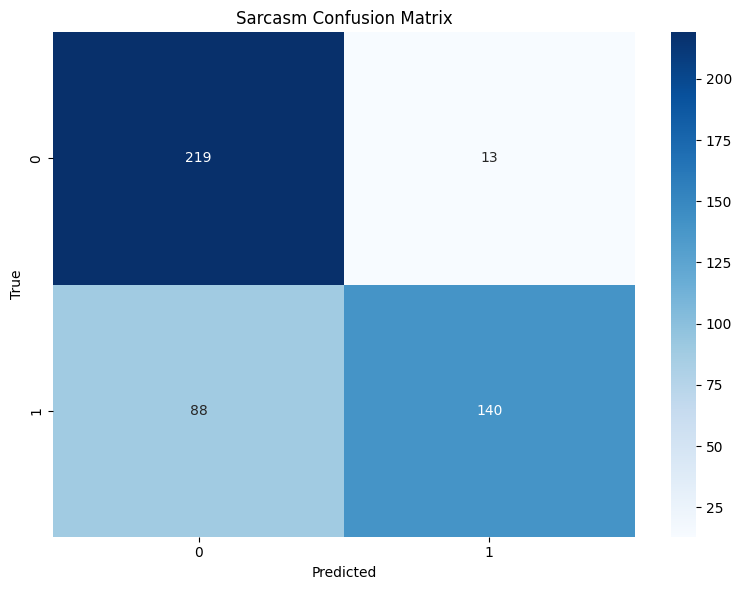

→ Validation Combined Macro F1: 0.6465

New best model found. Saving model state.
Best model saved to './results/train_val/best_multitask_model.pth'


-------------------------------------------

Epoch 2/5 completed.
→ Avg Emotion Loss: 0.8154, Avg Sarcasm Loss: 0.2722

Evaluating on training datasets...
Emotion Task Metrics:
task: emotion
accuracy: 0.8087
precision: 0.8034
recall: 0.7699
f1: 0.7846

Sarcasm Task Metrics:
task: sarcasm
accuracy: 0.9674
precision: 0.9681
recall: 0.9669
f1: 0.9673


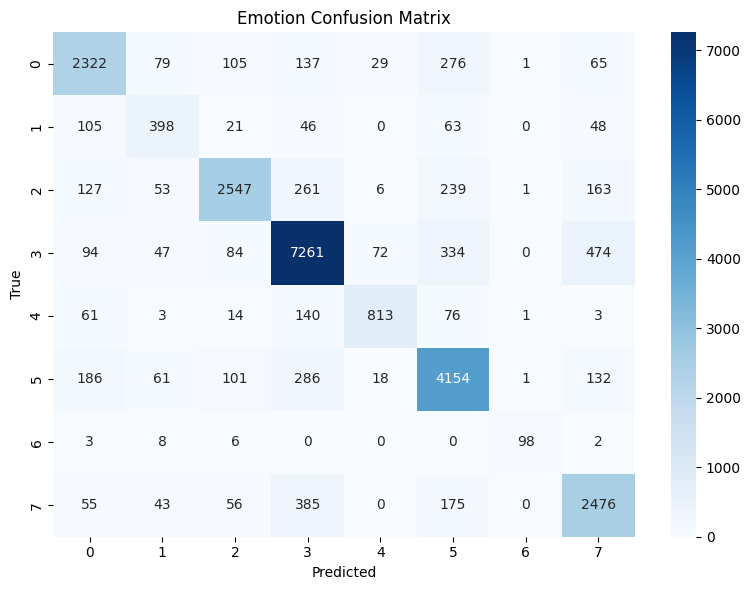

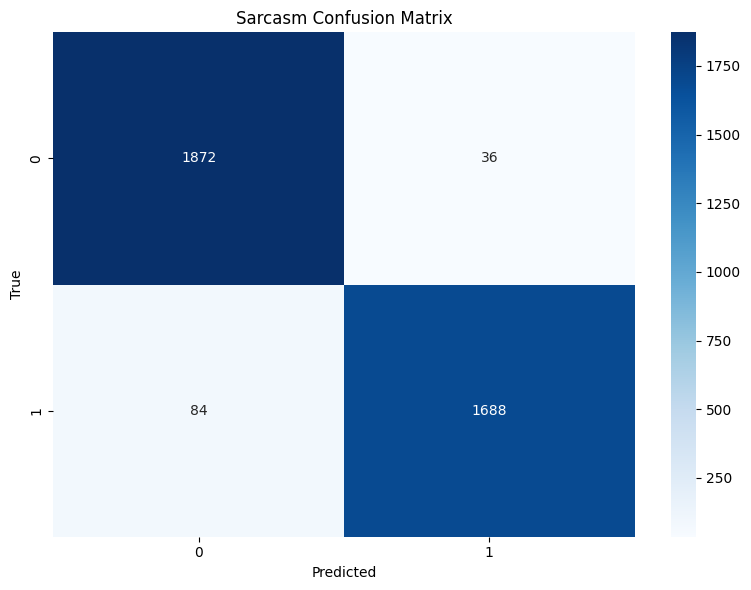

→ Training Combined Macro F1: 0.8760

Evaluating on validation datasets...
Emotion Task Metrics:
task: emotion
accuracy: 0.7279
precision: 0.7333
recall: 0.7165
f1: 0.7237

Sarcasm Task Metrics:
task: sarcasm
accuracy: 0.7804
precision: 0.7817
recall: 0.7801
f1: 0.7801


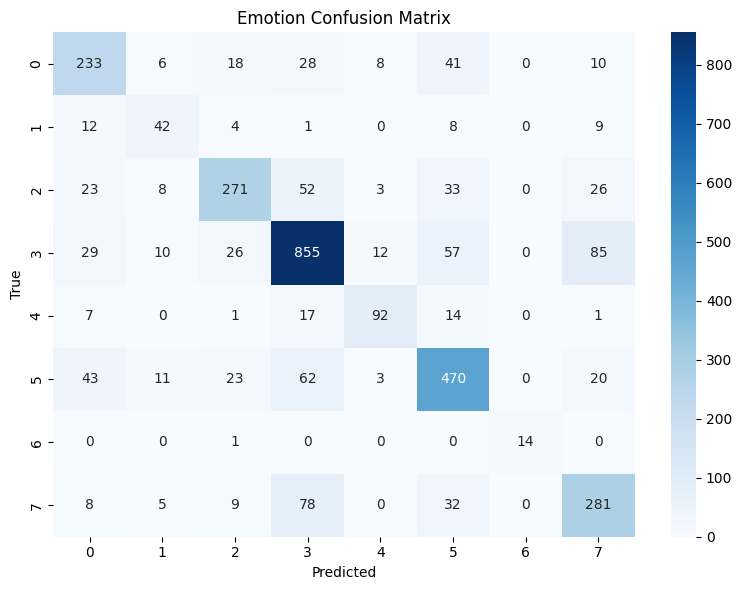

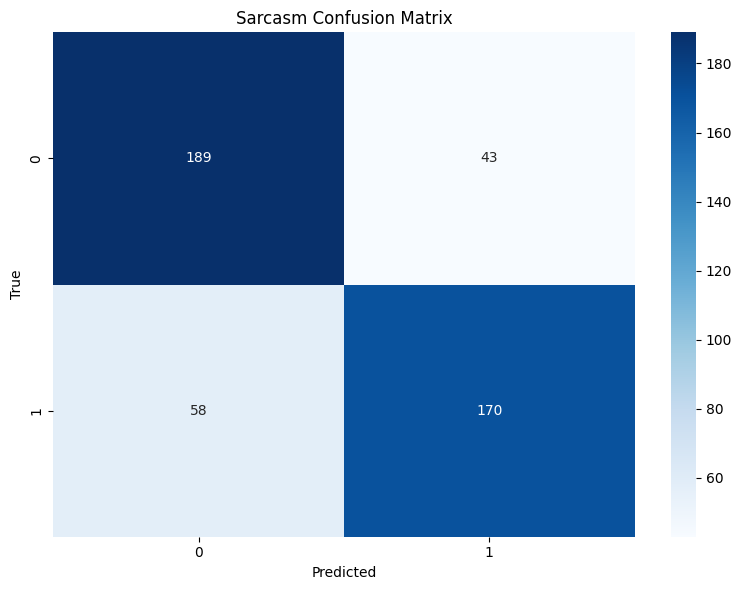

→ Validation Combined Macro F1: 0.7519

New best model found. Saving model state.
Best model saved to './results/train_val/best_multitask_model.pth'


-------------------------------------------

Epoch 3/5 completed.
→ Avg Emotion Loss: 0.6594, Avg Sarcasm Loss: 0.1194

Evaluating on training datasets...
Emotion Task Metrics:
task: emotion
accuracy: 0.8665
precision: 0.8623
recall: 0.8438
f1: 0.8480

Sarcasm Task Metrics:
task: sarcasm
accuracy: 0.9924
precision: 0.9923
recall: 0.9925
f1: 0.9924


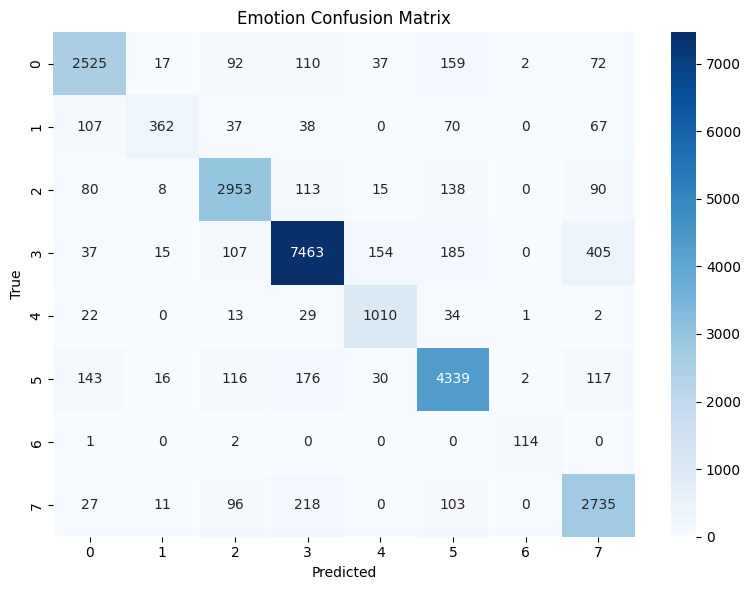

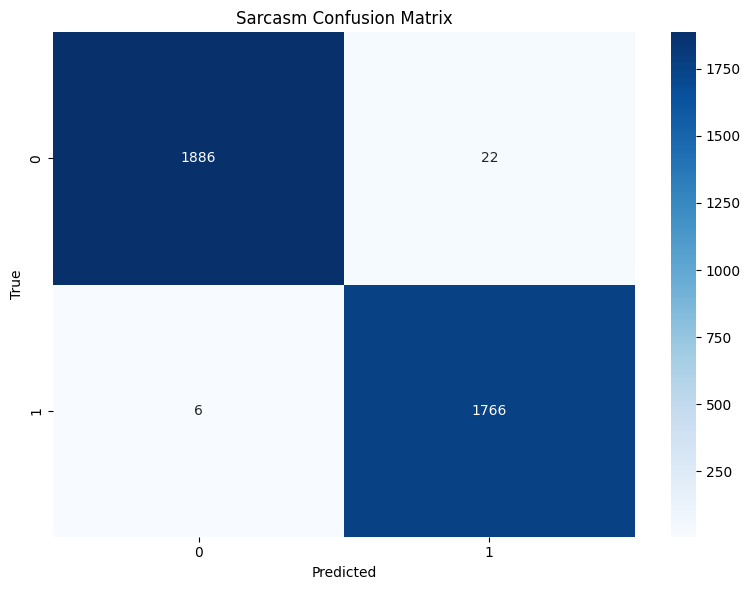

→ Training Combined Macro F1: 0.9202

Evaluating on validation datasets...
Emotion Task Metrics:
task: emotion
accuracy: 0.7386
precision: 0.7229
recall: 0.7289
f1: 0.7226

Sarcasm Task Metrics:
task: sarcasm
accuracy: 0.7696
precision: 0.7716
recall: 0.7699
f1: 0.7693


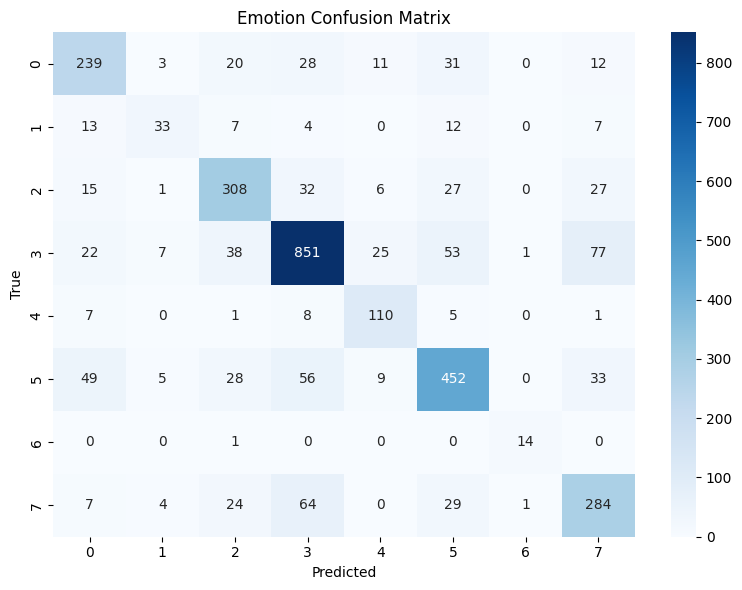

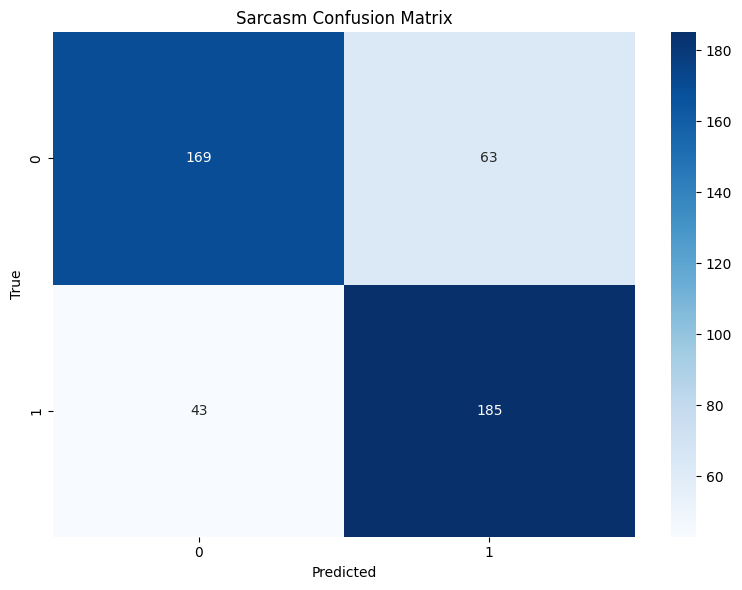

→ Validation Combined Macro F1: 0.7459

No improvement. Patience counter: 1


-------------------------------------------

Epoch 4/5 completed.
→ Avg Emotion Loss: 0.5296, Avg Sarcasm Loss: 0.0490

Evaluating on training datasets...
Emotion Task Metrics:
task: emotion
accuracy: 0.9001
precision: 0.8964
recall: 0.8858
f1: 0.8896

Sarcasm Task Metrics:
task: sarcasm
accuracy: 0.9986
precision: 0.9986
recall: 0.9986
f1: 0.9986


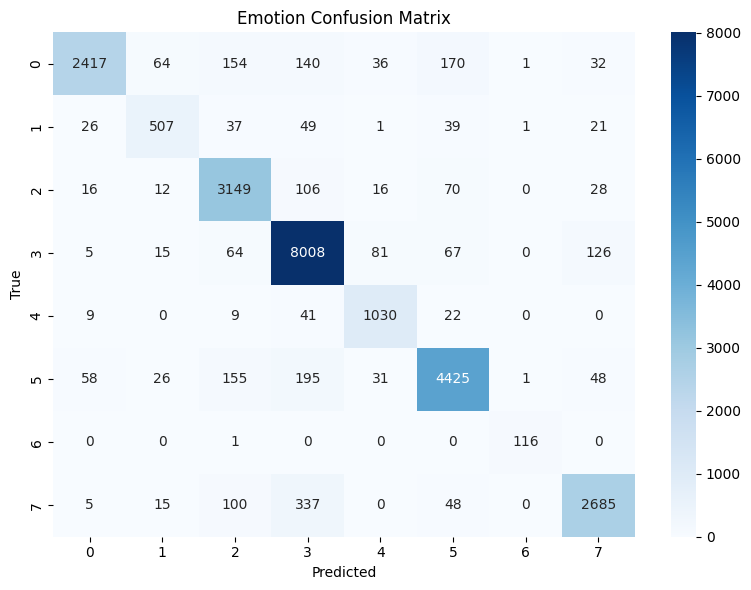

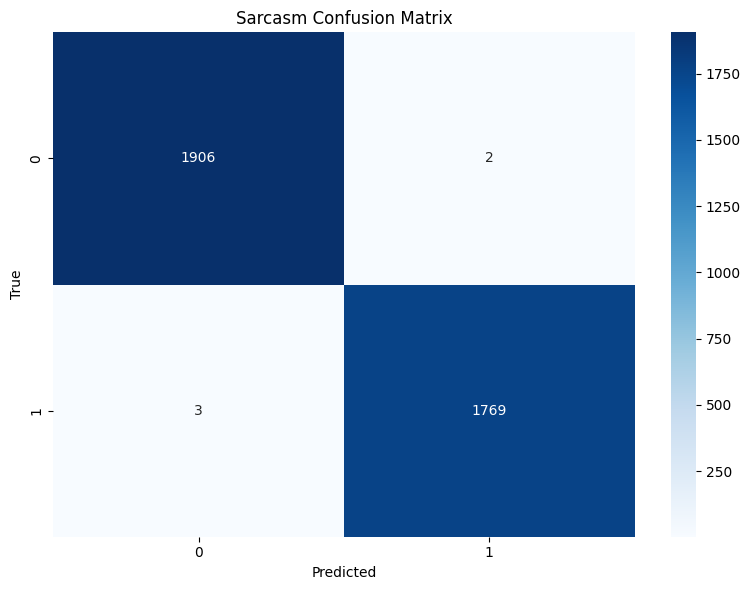

→ Training Combined Macro F1: 0.9441

Evaluating on validation datasets...
Emotion Task Metrics:
task: emotion
accuracy: 0.7437
precision: 0.7347
recall: 0.7339
f1: 0.7309

Sarcasm Task Metrics:
task: sarcasm
accuracy: 0.7804
precision: 0.7833
recall: 0.7800
f1: 0.7797


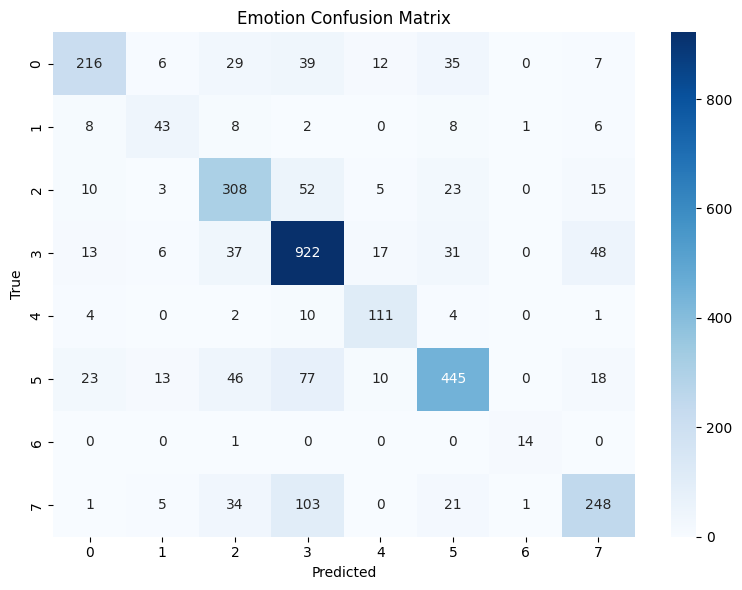

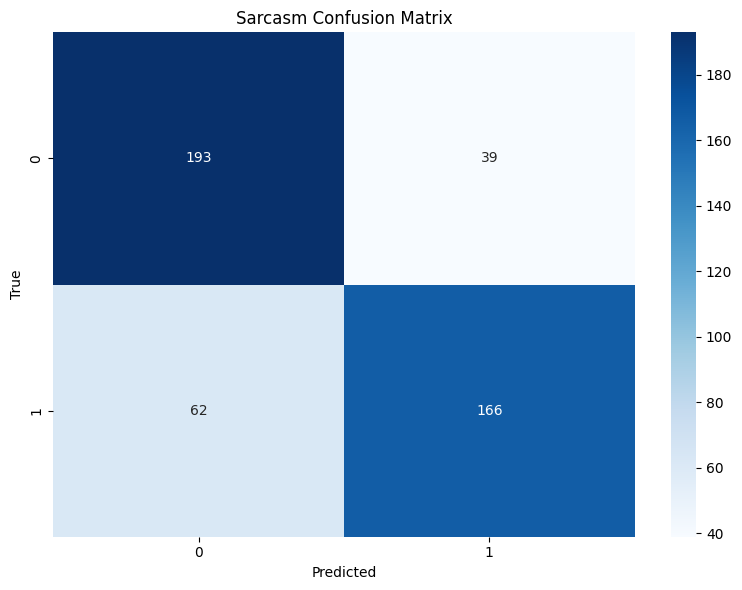

→ Validation Combined Macro F1: 0.7553

New best model found. Saving model state.
Best model saved to './results/train_val/best_multitask_model.pth'


-------------------------------------------

Epoch 5/5 completed.
→ Avg Emotion Loss: 0.4085, Avg Sarcasm Loss: 0.0270

Evaluating on training datasets...
Emotion Task Metrics:
task: emotion
accuracy: 0.9358
precision: 0.9314
recall: 0.9207
f1: 0.9246

Sarcasm Task Metrics:
task: sarcasm
accuracy: 0.9992
precision: 0.9992
recall: 0.9992
f1: 0.9992


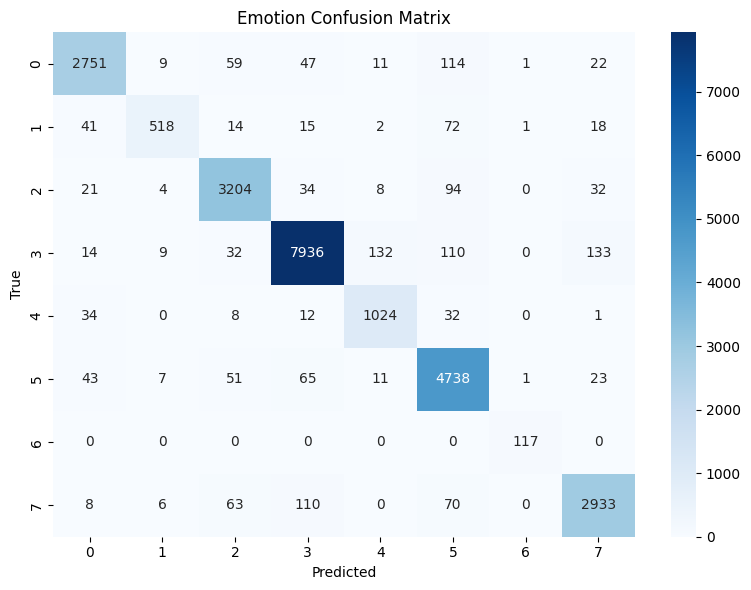

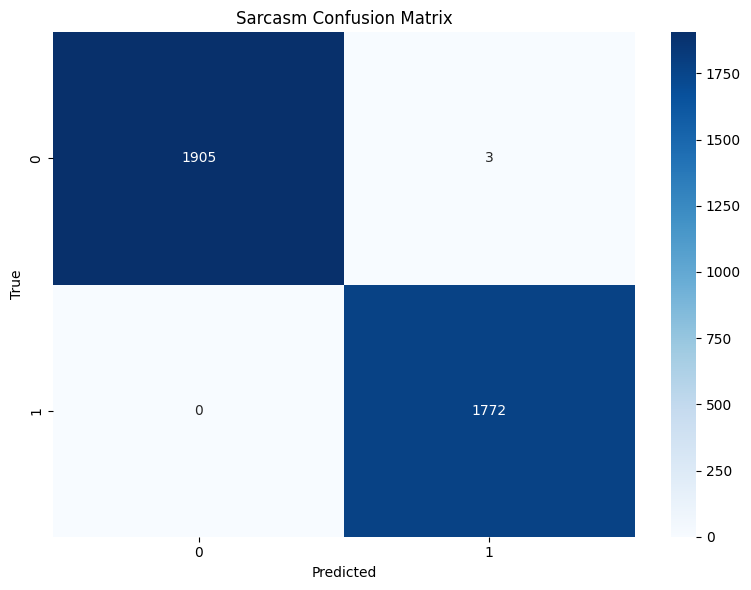

→ Training Combined Macro F1: 0.9619

Evaluating on validation datasets...
Emotion Task Metrics:
task: emotion
accuracy: 0.7405
precision: 0.7250
recall: 0.7338
f1: 0.7278

Sarcasm Task Metrics:
task: sarcasm
accuracy: 0.7696
precision: 0.7696
recall: 0.7696
f1: 0.7696


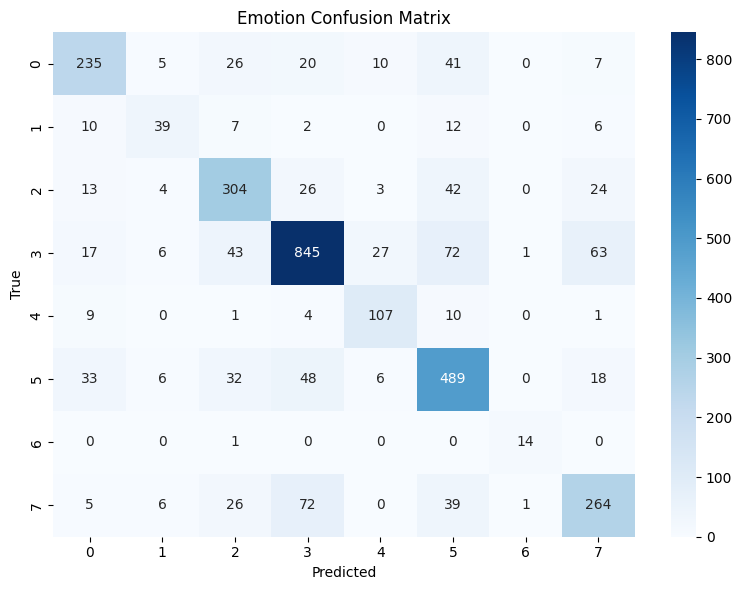

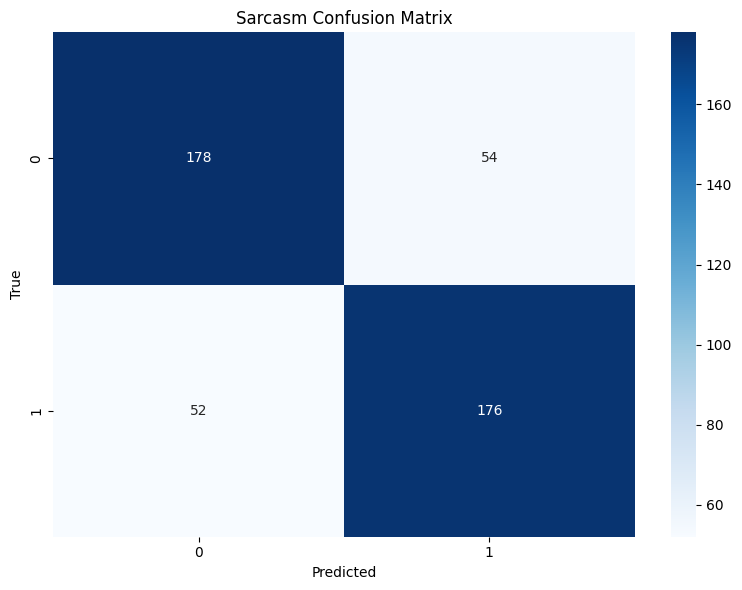

→ Validation Combined Macro F1: 0.7487

No improvement. Patience counter: 1
-----------------------------------
The best model evaluation on validation dataset:
Emotion Task Metrics:
task: emotion
accuracy: 0.7437
precision: 0.7347
recall: 0.7339
f1: 0.7309

Sarcasm Task Metrics:
task: sarcasm
accuracy: 0.7804
precision: 0.7833
recall: 0.7800
f1: 0.7797


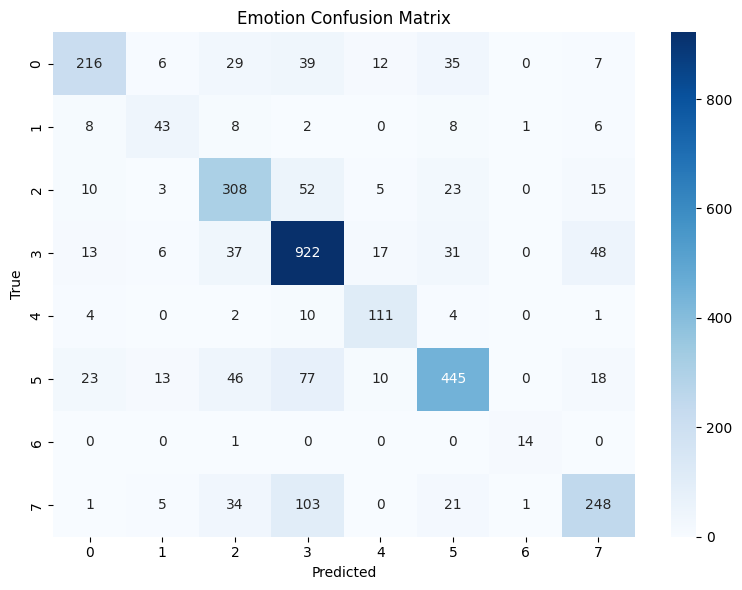

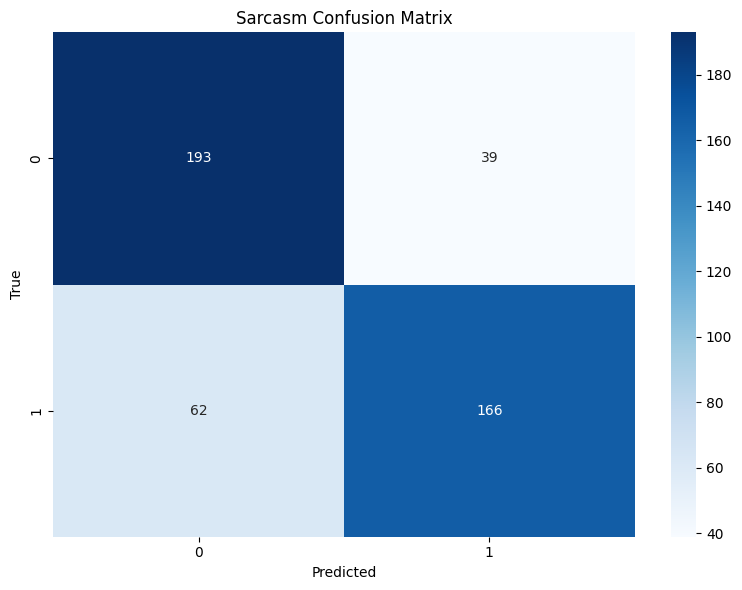

In [15]:
print("Start training...")
train_multitask(
    model,
    emotion_train_loader,
    sarcasm_train_loader,
    emotion_val_loader,
    sarcasm_val_loader,
    device,
    save_dir=train_val_results_dir,
    epochs=epochs,
    patience=patience,
    lr=learning_rate
)

The final best model is on the **4th epoch** with a training combined macro F1 = 0.9441; and a validation combined macro F1 = 0.7553

# **Evaluation on Testing datasets**

In [17]:
model.load_state_dict(torch.load(f"{train_val_results_dir}/best_multitask_model.pth"))
model.to(device)
model.eval()

MultiTaskModel(
  (bert): RobertaModel(
    (embeddings): RobertaEmbeddings(
      (word_embeddings): Embedding(64001, 768, padding_idx=1)
      (position_embeddings): Embedding(130, 768, padding_idx=1)
      (token_type_embeddings): Embedding(1, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): RobertaEncoder(
      (layer): ModuleList(
        (0-11): 12 x RobertaLayer(
          (attention): RobertaAttention(
            (self): RobertaSdpaSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): RobertaSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): Lay


Evaluating on testing datasets...
Emotion Task Metrics:
task: emotion
accuracy: 0.7186
precision: 0.7335
recall: 0.7075
f1: 0.7138

Sarcasm Task Metrics:
task: sarcasm
accuracy: 0.8178
precision: 0.8169
recall: 0.8187
f1: 0.8172


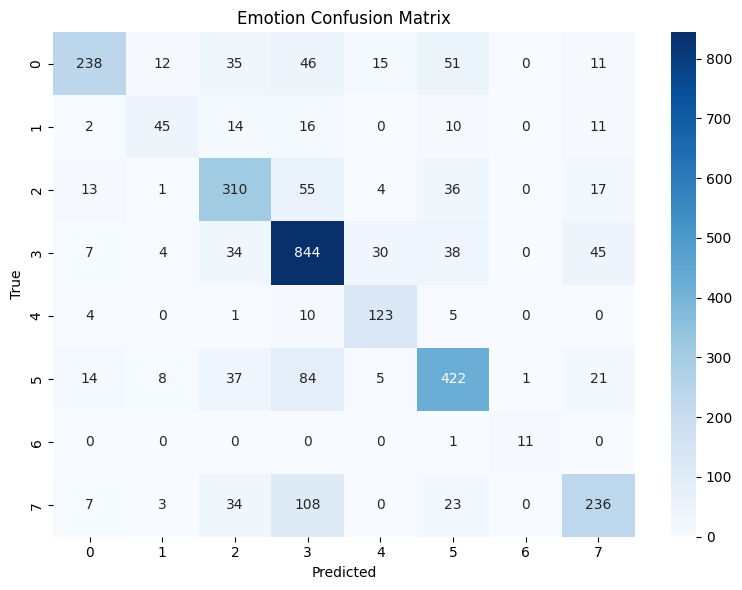

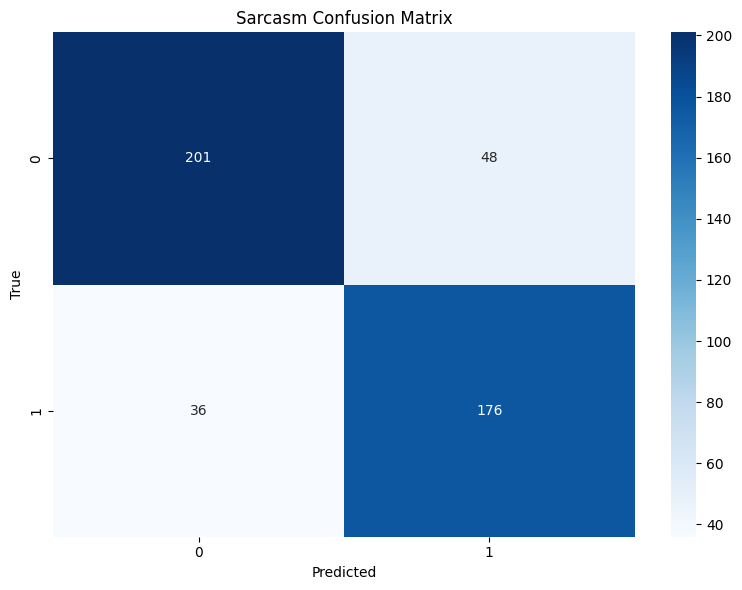

→ Testing Combined Macro F1: 0.7655


In [23]:
print("\nEvaluating on testing datasets...")
test_result_data, combined_macro_f1 = evaluate_multitask(
    model, emotion_test_loader, sarcasm_test_loader, device, save_dir=test_results_dir, save=True
)
print(f"→ Testing Combined Macro F1: {combined_macro_f1:.4f}")